In [1]:
%matplotlib inline
import cartopy.feature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import xarray as xr
import xesmf as xe
import mw_protocol.plotting as plotting
import mw_protocol.saving as saving
import mw_protocol.spreading as spreading
import mw_protocol.toolbox as tb
import seaborn as sns
import datetime

In [2]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("whitegrid")
sns.set_context("poster")

In [3]:
# To change for your personal folder if necessary
script_folder = "/nfs/see-fs-01_users/eeymr/work/scripts/mw_protocol/"

# Demonstration spreading algorithm

**Objective** : To avoid high peaks in meltwater distribution here is an alogithm to spread metlwater from collection boxes to spreading regions. This is added to the waterfix to create the final spread waterfix file.
- Collect routed meltwater points (m3/s) in collection boxes and distribute them to spreading regions overlaped with the 500m land sea mask (m3/s).
- Convert waterfix (kg/m2/s) to (m3/s). Add waterfix file (with nan replaced by 0) (m3/s).
- Check conservation of flux with a flux check.

*DIRECTLY ADAPTED FROM produce_deglacHadCM3_spread.py by R F Ivanovic*

## Main method

In [4]:
# Routed meltwater map
ds_routed = xr.open_dataset(f"{script_folder}/outputs/sample_routed_discharge.nc", decode_times=False)
lon_hadcm3, lat_hadcm3 = ds_routed.longitude.values, ds_routed.latitude.values
lon_hadcm3_b, lat_hadcm3_b = tb.create_coordinate_edges(lon_hadcm3), tb.create_coordinate_edges(lat_hadcm3)
routed_discharge = ds_routed.discharge

# Land-sea mask
ds_lsm = xr.open_dataset(f"{script_folder}/data/temev.qrparm.omask.nc")
lsm = ds_lsm.lsm.values

# Waterfix
ds_wfix = xr.open_dataset(f"{script_folder}/data/temev.qrparm.waterfix.nc")

surface_matrix = tb.surface_matrix(lon_hadcm3, lat_hadcm3)
routed_discharge = np.where(np.isnan(routed_discharge), 0, routed_discharge / 1000 * surface_matrix)

In [6]:
ds_spread = spreading.spreading(ds_routed, ds_lsm, ds_wfix)

__ Spreading algorithm
____ Spreading in {'name': 'US_East_Coast', 'loc': 147 ocean cells in the region, 'region': 125 ocean cells in the region}
____ Spreading in {'name': 'Greenland_Arctic', 'loc': 163 ocean cells in the region, 'region': 163 ocean cells in the region}
____ Spreading in {'name': 'N_American_Arctic', 'loc': 390 ocean cells in the region, 'region': 355 ocean cells in the region}
____ Spreading in {'name': 'Gulf_of_Mexico', 'loc': 96 ocean cells in the region, 'region': 72 ocean cells in the region}
____ Spreading in {'name': 'East_Pacific', 'loc': 292 ocean cells in the region, 'region': 270 ocean cells in the region}
____ Spreading in {'name': 'Russia_Pacific', 'loc': 21 ocean cells in the region, 'region': 12 ocean cells in the region}
____ Spreading in {'name': 'LabradorSea_BaffinBay', 'loc': 228 ocean cells in the region, 'region': 175 ocean cells in the region}
____ Spreading in {'name': 'Atlantic_GreenlandIceland', 'loc': 116 ocean cells in the region, 'region': 

In [7]:
ds_spread

<xarray.Dataset>
Dimensions:    (latitude: 144, longitude: 288, t: 5)
Coordinates:
  * t          (t) int64 -26000 -25900 -25800 -25700 -25600
  * latitude   (latitude) float32 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
Data variables:
    discharge  (t, latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    title:                SPREAD MELTWATER DISCHARGE
    start_year:           -26000
    end_year:             -25600
    step:                 100
    mode_lon:             double
    mode_shape:           cross
    running_mean_period:  0
    history:              Created 2022-11-29 16:26:59.695672 by Yvan Romé

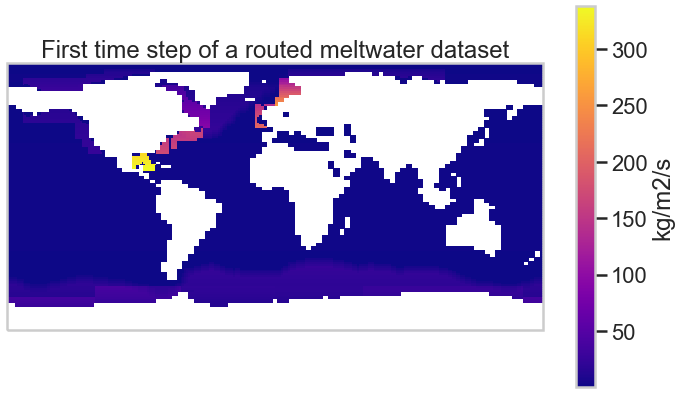

In [8]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(12,7))

# Masking method is necessary to transform 0 to nan.
cmap = axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, saving.masking_method(ds_spread.discharge[0], lsm), 
                        cmap='plasma', transform=ccrs.PlateCarree())
axMap.set_global()
axMap.set_title("First time step of a routed meltwater dataset")
figMap.colorbar(mappable=cmap, ax=axMap, label="kg/m2/s")

In [9]:
# We can save this intermediate output as data for the other demonstration notebooks.

# ds_spread.to_netcdf(f"{script_folder}/outputs/sample_spread_discharge.nc")

## TO MOVE TO SAVING : Omask to lsm

How is calculated GLAC-1D OMASK??\

In [11]:
ds_glac = xr.open_dataset(f"{script_folder}/data/sample/xpfjdo#da000078800c1+.nc").temp.isel(t=0).drop('t')
ds_glac

<xarray.DataArray 'temp' (depth: 20, latitude: 144, longitude: 290)>
[835200 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 357.5 358.8 360.0 361.2
  * latitude   (latitude) float32 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * depth      (depth) float32 5.0 15.0 25.0 ... 3.962e+03 4.577e+03 5.192e+03
Attributes:
    source:         Unified Model Output (Vn 4.5):
    name:           temp
    title:          POTENTIAL TEMPERATURE (OCEAN)  DEG.C
    date:           20/01/80
    time:           10:00
    long_name:      POTENTIAL TEMPERATURE (OCEAN)  DEG.C
    standard_name:  sea_water_potential_temperature
    units:          degC
    valid_min:      -12.193005
    valid_max:      33.994587

**Solved** The lsm is calculated from the shallowest ocean slice, 1 is land, 0 is ocean.

In [12]:
lsm_glac_um = xr.where(ds_glac.isel(depth=0).isnull(), 1, 0).rename('lsm').drop('depth')
lsm_glac_um

<xarray.DataArray 'lsm' (latitude: 144, longitude: 290)>
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]])
Coordinates:
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 357.5 358.8 360.0 361.2
  * latitude   (latitude) float32 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38

**Solved** The depthlevel field can be calculated through summing the non empty cells.

In [13]:
depthlevel_glac_um = xr.where(ds_glac.isnull(), np.nan, 1).sum('depth', skipna=True).astype(int)
depthlevel_glac_um = xr.where(depthlevel_glac_um>0, depthlevel_glac_um, np.nan)
depthlevel_glac_um

<xarray.DataArray 'temp' (latitude: 144, longitude: 290)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [19., 19., 19., ..., 19., 19., 19.],
       [19., 19., 19., ..., 19., 19., 19.],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 357.5 358.8 360.0 361.2
  * latitude   (latitude) float32 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38

**To solve** The depthlevel field can be calculated through summing the non empty cells.

In [30]:
def get_depthdepth(depthlevel, depth):
    depthdepth = np.copy(depthlevel)
    for i in range(depthdepth.shape[0]):
        for j in range(depthdepth.shape[1]):
            if ~np.isnan(depthlevel[i,j]):
                print(depthlevel[i,j])
                depthdepth = depth[depthlevel[i,j]]
    return depthdepth

In [33]:
depthlevel_glac_um.astype(int)

<xarray.DataArray 'temp' (latitude: 144, longitude: 290)>
array([[-9223372036854775808, -9223372036854775808, -9223372036854775808,
        ..., -9223372036854775808, -9223372036854775808,
        -9223372036854775808],
       [-9223372036854775808, -9223372036854775808, -9223372036854775808,
        ..., -9223372036854775808, -9223372036854775808,
        -9223372036854775808],
       [-9223372036854775808, -9223372036854775808, -9223372036854775808,
        ..., -9223372036854775808, -9223372036854775808,
        -9223372036854775808],
       ...,
       [                  19,                   19,                   19,
        ...,                   19,                   19,
                          19],
       [                  19,                   19,                   19,
        ...,                   19,                   19,
                          19],
       [-9223372036854775808, -9223372036854775808, -9223372036854775808,
        ..., -9223372036854775808, -9223372036854775808,
        -9223372036854775808]])
Coordinates:
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 357.5 358.8 360.0 361.2
  * latitude   (latitude) float32 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38

In [32]:
depthdepth = get_depthdepth(depthlevel_glac_um.astype(int).values, ds_glac.depth.values)
depthdepth

-9223372036854775808


IndexError: index -9223372036854775808 is out of bounds for axis 0 with size 20

In [14]:
def get_depth(i):
    return ds_glac.depth.values[i]

nan

In [15]:
ds_glac.depth.values

array([5.00000e+00, 1.50000e+01, 2.50000e+01, 3.51000e+01, 4.78500e+01,
       6.70000e+01, 9.57500e+01, 1.38900e+02, 2.03700e+02, 3.01000e+02,
       4.47050e+02, 6.66300e+02, 9.95550e+02, 1.50085e+03, 2.11615e+03,
       2.73140e+03, 3.34665e+03, 3.96190e+03, 4.57715e+03, 5.19245e+03],
      dtype=float32)

In [16]:
# def get_depth(depth, index):
#     return depth[index]
def get_depth(i):
    return ds_glac.depth.values[i]

In [17]:
depthlevel_glac_um.astype(int).to_dataset().map(get_depth)

IndexError: index -9223372036854775808 is out of bounds for axis 0 with size 20

In [ ]:
depthlevel_glac_um.astype(int)

In [ ]:
depthdepth_glac_um = xr.copy(depthlevel_glac_um)



In [ ]:
depthdepth_glac_um = xr.where(ds_glac.isel(depth=0).isnull(), 1, 0).rename('lsm').drop(depth)
lsm_glac_um

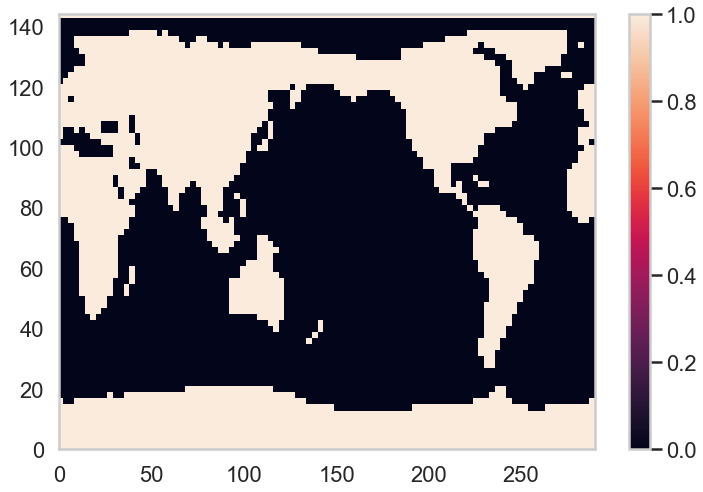

In [28]:
plt.pcolormesh(lsm_glac_um)
plt.colorbar()

In [16]:
ds_lsm_example = xr.open_dataset(f"{script_folder}/data/temev.qrparm.omask.nc")
ds_lsm_example

<xarray.Dataset>
Dimensions:     (latitude: 144, longitude: 288)
Coordinates:
  * longitude   (longitude) float32 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * latitude    (latitude) float32 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
Data variables:
    lsm         (latitude, longitude) float32 ...
    depthlevel  (latitude, longitude) float32 ...
    depthdepth  (latitude, longitude) float32 ...
Attributes:
    title:    Produced using writenc6 program by PJV

In [19]:
ds_omask = xr.open_dataset(f"{script_folder}/data/ice6g.omask.nc")
ds_omask


<xarray.Dataset>
Dimensions:    (depth: 20, latitude: 144, longitude: 290)
Coordinates:
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 357.5 358.8 360.0 361.2
  * latitude   (latitude) float32 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * depth      (depth) float32 5.0 15.0 25.0 ... 3.962e+03 4.577e+03 5.192e+03
    t          object ...
Data variables:
    omask      (depth, latitude, longitude) int64 ...

In [ ]:
lsm_new = ds_omask

## Respreading method

We need to respread the freshwater if we change the land seam mask for example. We use a new ocean mask in this case corresponding to ICE-6G

In [11]:
ds_spread_init = xr.open_dataset(f"{script_folder}/data/outputs/sample_spread_discharge.nc", decode_times=False)

ds_lsm_init = xr.open_dataset(f"{script_folder}/data/temev.qrparm.omask.nc")

ds_lsm_new = xr.open_dataset(f"{script_folder}/data/ice6g.omask.nc")


In [13]:
# We remove the waterfix from the initial spread file

ds_lsm_init



<xarray.Dataset>
Dimensions:     (latitude: 144, longitude: 288)
Coordinates:
  * longitude   (longitude) float32 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * latitude    (latitude) float32 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
Data variables:
    lsm         (latitude, longitude) float32 ...
    depthlevel  (latitude, longitude) float32 ...
    depthdepth  (latitude, longitude) float32 ...
Attributes:
    title:    Produced using writenc6 program by PJV

In [14]:
ds_lsm_new

<xarray.Dataset>
Dimensions:    (depth: 20, latitude: 144, longitude: 290)
Coordinates:
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 357.5 358.8 360.0 361.2
  * latitude   (latitude) float32 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * depth      (depth) float32 5.0 15.0 25.0 ... 3.962e+03 4.577e+03 5.192e+03
    t          object ...
Data variables:
    omask      (depth, latitude, longitude) int64 ...

In [ ]:
ds_respread = spreading.spreading(ds_sprea, ds_lsm, ds_wfix)

## Inputs

**Land Sea Mask :** Surface and 500m land sea mask.

Text(0.5, 1.0, 'Land sea mask - 500m')

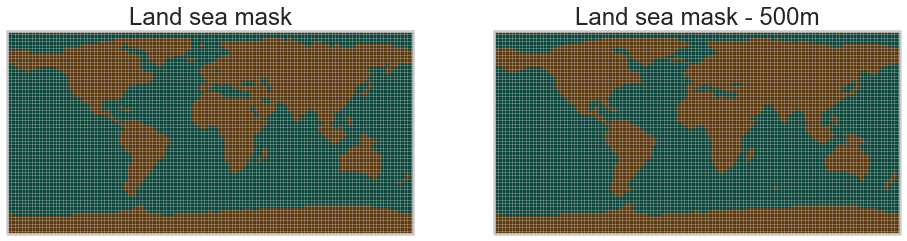

In [6]:
ds_lsm = xr.open_dataset(f"{script_folder}/data/temev.qrparm.omask.nc")
lon_lsm, lat_lsm, depth, lsm = ds_lsm.longitude.values, ds_lsm.latitude.values, ds_lsm.depthdepth.values, ds_lsm.lsm.values
lon_lsm_b, lat_lsm_b = tb.create_coordinate_edges(lon_lsm), tb.create_coordinate_edges(lat_lsm)

masked = np.copy(lsm)  # land mask True (1) on land
depthm = np.ma.masked_less(depth, 500.0)  # mask areas shallower than 500m
masked_500m = np.copy(depthm.mask) + masked  # create binary mask from depth data

projection_map = ccrs.PlateCarree()

figMap,(axMask, ax500) = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection':projection_map}, figsize=(16,8))
axMask.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, masked, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
axMask.set_title("Land sea mask")
ax500.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, masked_500m, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
ax500.set_title("Land sea mask - 500m")

**Routed mask :** 3 dimensional routed poitnlike meltwater mask (routing algorithm outcome). Because the saving algorithm deal with a flux per surface, we also need to convert the meltwater_discharge *(kg/m2/s -> m3/s)*.

In [7]:
ds_routed = xr.open_dataset(f"{script_folder}/data/sample_routed_discharge.nc", decode_times=False)
lon_hadcm3, lat_hadcm3 = ds_routed.longitude.values, ds_routed.latitude.values
lon_hadcm3_b, lat_hadcm3_b = tb.create_coordinate_edges(lon_hadcm3), tb.create_coordinate_edges(lat_hadcm3)
discharge = ds_routed.routed_discharge

surface_matrix = tb.surface_matrix(lon_hadcm3, lat_hadcm3)
discharge = np.where(np.isnan(discharge), 0, discharge / 1000 * surface_matrix)

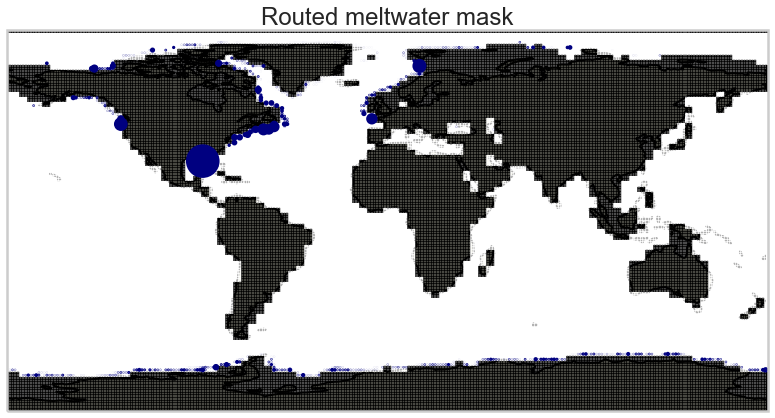

In [8]:
projection_map = ccrs.PlateCarree()

figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))

axMap.pcolormesh(lon_lsm_b, lat_lsm_b, lsm, transform=ccrs.PlateCarree(),cmap="binary", alpha=0.7)

x,y,s = tb.scatter_mask(discharge[-1])
axMap.scatter(lon_hadcm3[x], lat_hadcm3[y], transform=ccrs.PlateCarree(), s=10*s, color="navy")
axMap.set_global()
axMap.set_title("Routed meltwater mask")
axMap.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

**Waterfix** : 2 dimenstion (lat*lon) hadcm3 meltwater discharge

In [9]:
ds_wfix = xr.open_dataset(f"{script_folder}/data/temev.qrparm.waterfix.nc")

lon_wfix, lat_wfix = ds_wfix.longitude.values[:-2], ds_wfix.latitude.values
lon_wfix_b, lat_wfix_b = tb.create_coordinate_edges(lon_wfix), lat_wfix
wfix = ds_wfix.field672.isel(depth=0).isel(t=0)[:, :-2]

ds_wfix

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 144, longitude: 290, t: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 357.5 358.8 360.0 361.2
  * latitude   (latitude) float32 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * depth      (depth) float32 5.0
  * t          (t) object 1800-12-01 00:00:00
Data variables:
    field672   (t, depth, latitude, longitude) float32 ...
Attributes:
    history:  Thu Jan 18 08:19:59 GMT 2018 - CONVSH V1.91 16-February-2006

/nfs/see-fs-01_users/eeymr/.conda/envs/eeymr/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


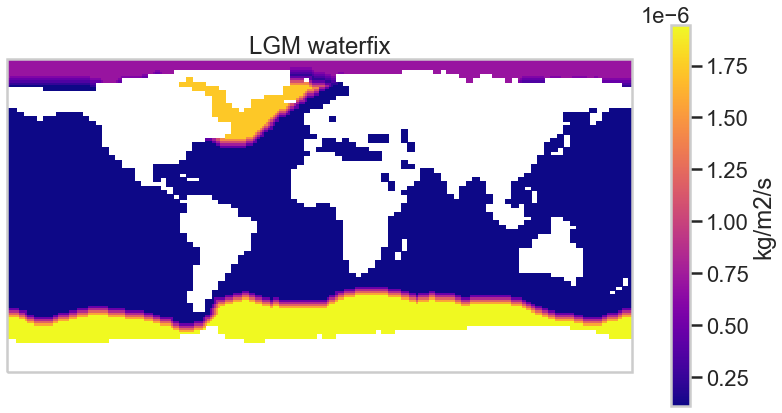

In [10]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))

cmap = axMap.pcolormesh(lon_wfix_b, lat_wfix_b, wfix, cmap='plasma', transform=ccrs.PlateCarree())
axMap.set_global()
axMap.set_title("LGM waterfix")
figMap.colorbar(mappable=cmap, ax=axMap, label="kg/m2/s")

## Step 1 : Generate collection and spreading zones

### Defining collection boxes

In [11]:
cb = spreading.generate_collection_boxes()
cb

{'USECoast1': None ocean cells in the box,
 'USECoast2': None ocean cells in the box,
 'USECoast3': None ocean cells in the box,
 'USECoast4': None ocean cells in the box,
 'USECoast5': None ocean cells in the box,
 'USECoast6': None ocean cells in the box,
 'GrArc1': None ocean cells in the box,
 'NAMArc1': None ocean cells in the box,
 'NAMArc2': None ocean cells in the box,
 'NAMArc3': None ocean cells in the box,
 'NAMArc4': None ocean cells in the box,
 'NAMArc5': None ocean cells in the box,
 'NWTerr1': None ocean cells in the box,
 'NWTerr2': None ocean cells in the box,
 'GrLakes1': None ocean cells in the box,
 'GoM1': None ocean cells in the box,
 'EPac1': None ocean cells in the box,
 'EPac2': None ocean cells in the box,
 'EPac3': None ocean cells in the box,
 'EPac4': None ocean cells in the box,
 'EPac5': None ocean cells in the box,
 'RussPac1': None ocean cells in the box,
 'BafLab1': None ocean cells in the box,
 'BafLab2': None ocean cells in the box,
 'BafLab3': None

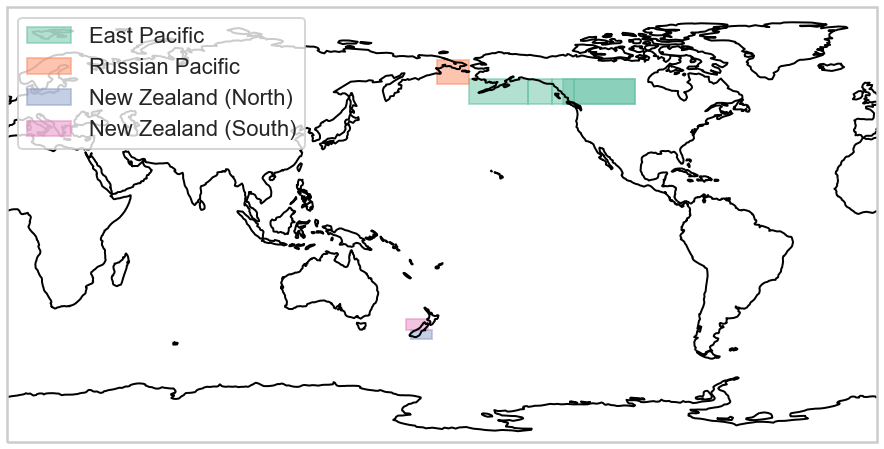

In [12]:
# PACIFIC

projection_map = ccrs.PlateCarree(central_longitude=180.0)
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))

# c_list = plt.cm.turbo(np.linspace(0.05, 0.95, 4))
c_list = plt.cm.Set2


# East Pacific
for box in ["EPac1", "EPac2", "EPac3", "EPac4", "EPac5"]:
    axMap.fill(cb[box].cycle_box()[0], cb["EPac1"].cycle_box()[1], 
               color=c_list(0), linestyle = "-", alpha=0.5, transform=ccrs.PlateCarree())
axMap.fill([],[], color=c_list(0), linestyle = "-", alpha=0.5, label="East Pacific")

# Russia Pacific
axMap.fill(cb["RussPac1"].cycle_box()[0], cb["RussPac1"].cycle_box()[1], 
           color=c_list(1), linestyle = "-", alpha=0.5, transform=ccrs.PlateCarree(), label="Russian Pacific")

# New Zealand (South)
axMap.fill(cb["SNZPac1"].cycle_box()[0], cb["SNZPac1"].cycle_box()[1], 
           color=c_list(2), linestyle = "-", alpha=0.5, transform=ccrs.PlateCarree(), label="New Zealand (North)")

# New Zealand (North)
axMap.fill(cb["NNZPac1"].cycle_box()[0], cb["NNZPac1"].cycle_box()[1], 
           color=c_list(3), linestyle = "-", alpha=0.5, transform=ccrs.PlateCarree(), label="New Zealand (South)")

axMap.set_global()
axMap.coastlines()
axMap.legend(loc="upper left")

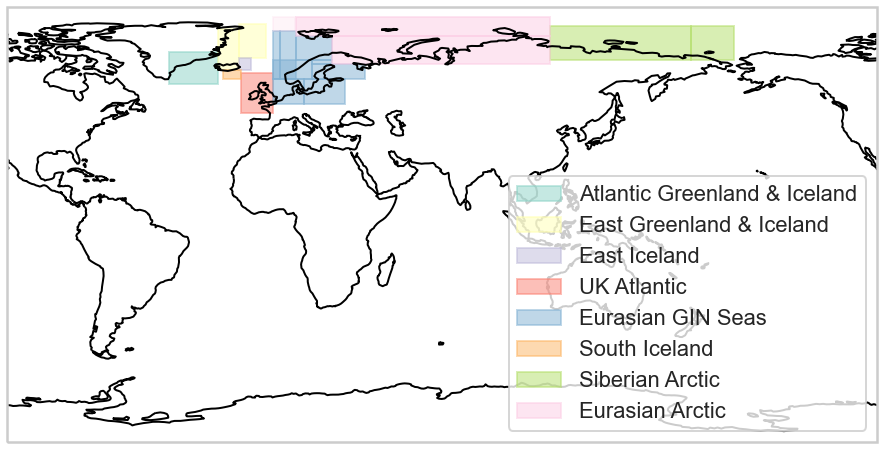

In [13]:
# ARCTIC AND GIN SEAS

projection_map = ccrs.PlateCarree(central_longitude=70.0)
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))

# c_list = plt.cm.turbo(np.linspace(0.05, 0.95, 4))
c_list = plt.cm.Set3


# Atlantic Greenland Iceland
axMap.fill(cb["AtlGr1"].cycle_box()[0], cb["AtlGr1"].cycle_box()[1], 
           color=c_list(0), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Atlantic Greenland & Iceland")

# E Greenland & Iceland
axMap.fill(cb["EGrIce1"].cycle_box()[0], cb["EGrIce1"].cycle_box()[1], 
           color=c_list(1), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="East Greenland & Iceland")
axMap.fill(cb["EGrIce2"].cycle_box()[0], cb["EGrIce2"].cycle_box()[1], 
           color=c_list(1), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())

# E Iceland
axMap.fill(cb["EIceland1"].cycle_box()[0], cb["EIceland1"].cycle_box()[1], 
           color=c_list(2), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="East Iceland")

# UK Atlantic
axMap.fill(cb["UKAtl1"].cycle_box()[0], cb["UKAtl1"].cycle_box()[1], 
           color=c_list(3), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="UK Atlantic")

# Eurasian GIN Seas
for box in ["EurGIN1", "EurGIN2", "EurGIN3", "EurGIN4", "EurGIN5", "EurGIN6", "Baltic1", "Baltic2"] :
    axMap.fill(cb[box].cycle_box()[0], cb[box].cycle_box()[1], 
               color=c_list(4), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill([], [], color=c_list(4), linestyle = "-", alpha = 0.5, label="Eurasian GIN Seas")

# South Iceland
axMap.fill(cb["SIceland1"].cycle_box()[0], cb["SIceland1"].cycle_box()[1], 
           color=c_list(5), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="South Iceland")

# Siberian Arctic
axMap.fill(cb["SibArc1"].cycle_box()[0], cb["SibArc1"].cycle_box()[1], 
           color=c_list(6), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Siberian Arctic")
axMap.fill(cb["SibArc2"].cycle_box()[0], cb["SibArc2"].cycle_box()[1], 
           color=c_list(6), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())

# Eurasian Arctic
axMap.fill(cb["EurArc1"].cycle_box()[0], cb["EurArc1"].cycle_box()[1], 
           color=c_list(7), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Eurasian Arctic")
axMap.fill(cb["EurArc2"].cycle_box()[0], cb["EurArc2"].cycle_box()[1], 
           color=c_list(7), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["EurArc3"].cycle_box()[0], cb["EurArc3"].cycle_box()[1], 
           color=c_list(7), linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())

axMap.set_global()
axMap.coastlines()
axMap.legend(loc="lower right")

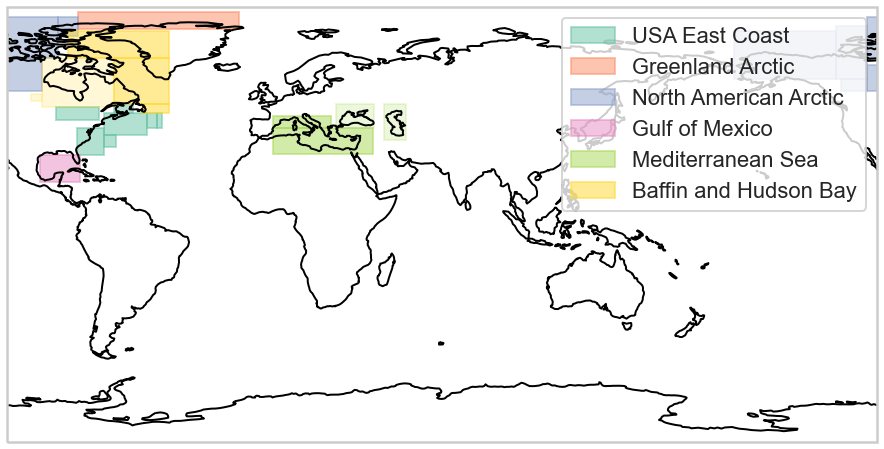

In [14]:
projection_map = ccrs.PlateCarree(central_longitude=70.0)
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))

c_list = plt.cm.Set2

## NORTH ATLANTIC

# USA East Coast
for box in ["USECoast1", "USECoast2", "USECoast3", "USECoast4", "USECoast5", "USECoast6", "GrLakes1"]:
    axMap.fill(cb[box].cycle_box()[0], cb[box].cycle_box()[1], 
               color=c_list(0), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill([], [], color=c_list(0), linestyle = "-", alpha = 0.5, label="USA East Coast")

# Greenland Arctic
axMap.fill(cb["GrArc1"].cycle_box()[0], cb["GrArc1"].cycle_box()[1], 
           color=c_list(1), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Greenland Arctic")

# North American Arctic
for box in ["NAMArc1", "NAMArc2", "NAMArc3", "NAMArc4", "NAMArc5", "NWTerr1", "NWTerr2"]:
    axMap.fill(cb[box].cycle_box()[0], cb[box].cycle_box()[1], 
               color=c_list(2), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill([], [], color=c_list(2), linestyle = "-", alpha = 0.5, label="North American Arctic")

# Gulf of Mexico
axMap.fill(cb["GoM1"].cycle_box()[0], cb["GoM1"].cycle_box()[1], 
           color=c_list(3), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Gulf of Mexico")

# Mediterranean
axMap.fill(cb["Med1"].cycle_box()[0], cb["Med1"].cycle_box()[1], 
           color=c_list(4), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Mediterranean Sea")
axMap.fill(cb["Med2"].cycle_box()[0], cb["Med2"].cycle_box()[1], 
           color=c_list(4), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["BlckSea1"].cycle_box()[0], cb["BlckSea1"].cycle_box()[1], 
           color=c_list(4), linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())
axMap.fill(cb["CaspSea1"].cycle_box()[0], cb["CaspSea1"].cycle_box()[1], 
           color=c_list(4), linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())

# Labrador Sea & Baffin Bay
axMap.fill(cb["BafLab1"].cycle_box()[0], cb["BafLab1"].cycle_box()[1], 
           color=c_list(5), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Baffin and Hudson Bay")
axMap.fill(cb["BafLab2"].cycle_box()[0], cb["BafLab2"].cycle_box()[1], 
           color=c_list(5), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["BafLab3"].cycle_box()[0], cb["BafLab3"].cycle_box()[1], 
           color=c_list(5), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["HudBay1"].cycle_box()[0], cb["HudBay1"].cycle_box()[1], 
           color=c_list(5), linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())
axMap.fill(cb["HudBay2"].cycle_box()[0], cb["HudBay2"].cycle_box()[1], 
           color=c_list(5), linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())

axMap.set_global()
axMap.coastlines()
axMap.legend(loc="upper right")

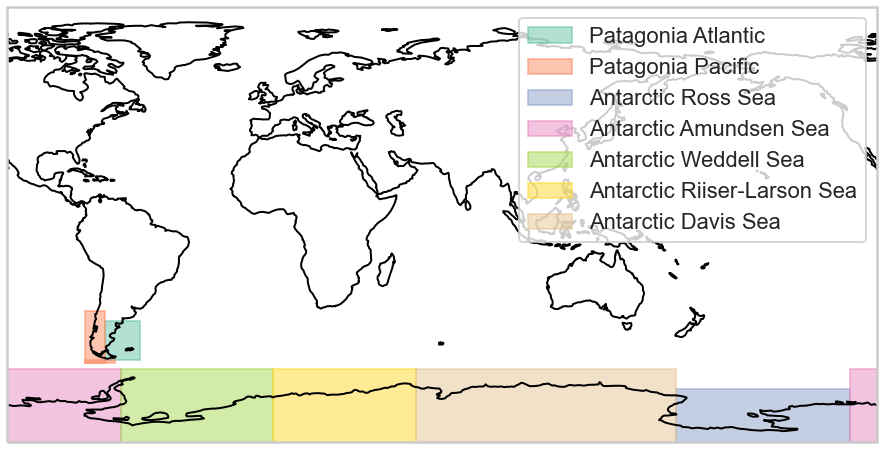

In [15]:
projection_map = ccrs.PlateCarree(central_longitude=70.0)
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))

c_list = plt.cm.Set2

## ANTARCTICA


# Patagonia Atlantic
axMap.fill(cb["PatAtl1"].cycle_box()[0], cb["PatAtl1"].cycle_box()[1], 
           color=c_list(0), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Patagonia Atlantic")

# Patagonia Pacific
axMap.fill(cb["PatPac1"].cycle_box()[0], cb["PatPac1"].cycle_box()[1], 
           color=c_list(1), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Patagonia Pacific")
axMap.fill(cb["PatPac2"].cycle_box()[0], cb["PatPac2"].cycle_box()[1], 
           color=c_list(1), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())

# Antarctic Ross Sea
axMap.fill(cb["AARos1"].cycle_box()[0], cb["AARos1"].cycle_box()[1], 
           color=c_list(2), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Antarctic Ross Sea")

# Antarctic Amundsen Sea
axMap.fill(cb["AAAmund"].cycle_box()[0], cb["AAAmund"].cycle_box()[1], 
           color=c_list(3), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Antarctic Amundsen Sea")

# Antarctic Weddell Sea
axMap.fill(cb["AAWeddell"].cycle_box()[0], cb["AAWeddell"].cycle_box()[1], 
           color=c_list(4), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Antarctic Weddell Sea")

# Antarctic Riiser-Larson Sea
axMap.fill(cb["AARiiLar"].cycle_box()[0], cb["AARiiLar"].cycle_box()[1], 
           color=c_list(5), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Antarctic Riiser-Larson Sea")

# Antarctic Davis Sea
axMap.fill(cb["AADavis"].cycle_box()[0], cb["AADavis"].cycle_box()[1], 
           color=c_list(6), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Antarctic Davis Sea")

axMap.set_global()
axMap.coastlines()
axMap.legend(loc="upper right")

### Defining spreading regions

In [16]:
lat, lon = spreading.LatAxis(lat_wfix[:]), spreading.LonAxis(lon_wfix[:])
umgrid = spreading.Grid(lat, lon)

sr = spreading.generate_spreading_regions(cb, umgrid, masked, masked_500m)

/nfs/see-fs-01_users/eeymr/.conda/envs/eeymr/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


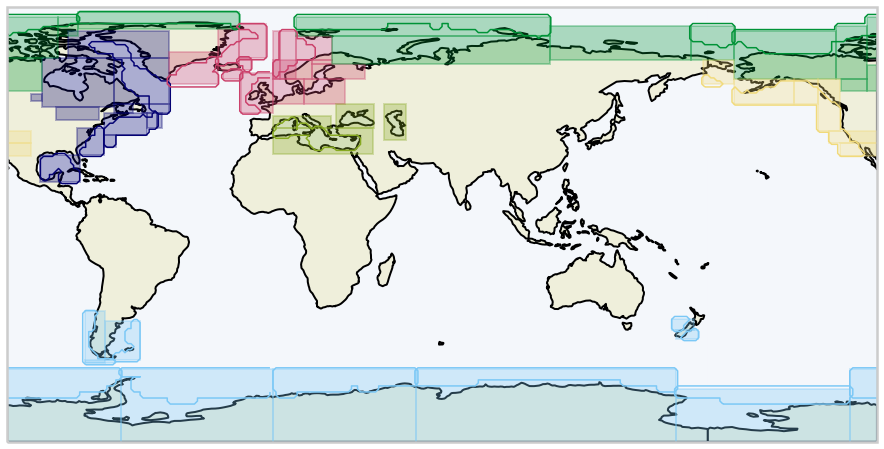

In [17]:
projection_map = ccrs.PlateCarree(central_longitude=70.0)
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))

colors_region = {'elwg': 'xkcd:deep blue', 'gin':'xkcd:dark pink', 'med':'xkcd:avocado green', 'arc':'xkcd:kelley green', 
                'so':'xkcd:lightblue', 'wl':'xkcd:sandy', 'tot':'xkcd:black'}

# COLLECTION BOXES

# East Laurentide and West Greenland

axMap.fill(cb['USECoast1'].cycle_box()[0], cb['USECoast1'].cycle_box()[1], color=colors_region['elwg'],
           linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree(), label="East Laurentide and West Greenland")
for region in ['USECoast2', 'USECoast3', 'USECoast4', 'USECoast5', 'USECoast6', 'GrLakes1', 'GoM1', 'BafLab1',
               'BafLab2', 'BafLab3', 'HudBay1', 'HudBay2']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color=colors_region['elwg'], linestyle = "-",
               alpha=0.3, transform=ccrs.PlateCarree())

# GIN seas

axMap.fill(cb['AtlGr1'].cycle_box()[0], cb['AtlGr1'].cycle_box()[1], color=colors_region['gin'], linestyle = "-", 
           alpha=0.3, transform=ccrs.PlateCarree(), label="GIN seas")
for region in ['EGrIce1', 'EGrIce2', 'EIceland1', 'SIceland1', 'UKAtl1', 'EurGIN1', 'EurGIN2', 'EurGIN3', 'EurGIN4',
               'EurGIN5', 'EurGIN6', 'Baltic1', 'Baltic2']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color=colors_region['gin'], linestyle = "-",
               alpha=0.3, transform=ccrs.PlateCarree())
    
# Arctic

axMap.fill(cb['GrArc1'].cycle_box()[0], cb['GrArc1'].cycle_box()[1], color=colors_region['arc'], linestyle = "-",
           alpha=0.3, transform=ccrs.PlateCarree(), label="Arctic")
for region in ['NAMArc1', 'NAMArc2', 'NAMArc3', 'NAMArc4', 'NAMArc5', 'NWTerr1', 'NWTerr2', 'SibArc1',
               'SibArc2', 'EurArc1', 'EurArc2']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color=colors_region['arc'], linestyle = "-", 
               alpha=0.3, transform=ccrs.PlateCarree())

# Southern ocean

axMap.fill(cb['PatAtl1'].cycle_box()[0], cb['PatAtl1'].cycle_box()[1], color=colors_region['so'], linestyle = "-", 
           alpha=0.3, transform=ccrs.PlateCarree(), label="Southern Ocean")
for region in ['PatPac1', 'PatPac2', 'AARos1', 'AAAmund', 'AAWeddell', 'AARiiLar', 'AADavis', 'SNZPac1', 'NNZPac1']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color=colors_region['so'], linestyle = "-",
               alpha=0.3, transform=ccrs.PlateCarree())

# Pacific

axMap.fill(cb['EPac1'].cycle_box()[0], cb['EPac1'].cycle_box()[1], color=colors_region['wl'], linestyle = "-", 
           alpha=0.3, transform=ccrs.PlateCarree(), label="Pacific")
for region in ['EPac2', 'EPac3', 'EPac4', 'EPac5', 'RussPac1']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color=colors_region['wl'], linestyle = "-", 
               alpha=0.3, transform=ccrs.PlateCarree())

# Mediterannean Sea

axMap.fill(cb['Med1'].cycle_box()[0], cb['Med1'].cycle_box()[1], color=colors_region['med'], linestyle = "-", alpha=0.3,
           transform=ccrs.PlateCarree(), label="Mediterranean Sea")
for region in ['Med2', 'BlckSea1', 'CaspSea1']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color=colors_region['med'], linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree())

    
# SPREADING REGIONDS

for region in sr:
    if region['name'] in ['US_East_Coast', 'Gulf_of_Mexico', 'LabradorSea_BaffinBay']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask, 
                      levels=[True], colors=colors_region['elwg'], transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['Greenland_Arctic', 'N_American_Arctic', 'Eurasian_Arctic', 'Siberian_Arctic']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask,
                      levels=[True], colors=colors_region['arc'], transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['East_Pacific', 'Russia_Pacific']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask,
                      levels=[True], colors=colors_region['wl'], transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['Atlantic_GreenlandIceland', 'EastGreenland_Iceland', 'EastIceland']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask,
                      levels=[True], colors=colors_region['gin'], transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['UK_Atlantic', 'Eurasian_GINSeas', 'South_Iceland']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask,
                      levels=[True], colors=colors_region['gin'], transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['Mediterranean']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask,
                      levels=[True], colors=colors_region['med'], transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['Patagonia_Atlantic', 'Patagonia_Pacific', 'NorthNewZealand_Pacific', 'SouthNewZealand_Pacific', 'Antarctica_RossSea', 'Antarctica_AmundsenSea', 'Antarctica_WeddellSea', 'Antarctica_RiiserLarsonSea', 'Antarctica_DavisSea']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask, 
                      levels=[True], colors=colors_region['so'], transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)

axMap.set_global()
axMap.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
axMap.add_feature(cartopy.feature.OCEAN, zorder=-1, edgecolor='black', lw=0, alpha=0.1)


## Step 2 - Spread the collected freshwater in the spreading zones

In [18]:
spread_discharge = spreading.spreading_method(routed_discharge, sr, tb.surface_matrix(lon_lsm, lat_lsm))

____ Spreading in {'name': 'US_East_Coast', 'loc': 147 ocean cells in the region, 'region': 125 ocean cells in the region}
____ Spreading in {'name': 'Greenland_Arctic', 'loc': 163 ocean cells in the region, 'region': 163 ocean cells in the region}
____ Spreading in {'name': 'N_American_Arctic', 'loc': 390 ocean cells in the region, 'region': 355 ocean cells in the region}
____ Spreading in {'name': 'Gulf_of_Mexico', 'loc': 96 ocean cells in the region, 'region': 72 ocean cells in the region}
____ Spreading in {'name': 'East_Pacific', 'loc': 292 ocean cells in the region, 'region': 270 ocean cells in the region}
____ Spreading in {'name': 'Russia_Pacific', 'loc': 21 ocean cells in the region, 'region': 12 ocean cells in the region}
____ Spreading in {'name': 'LabradorSea_BaffinBay', 'loc': 228 ocean cells in the region, 'region': 175 ocean cells in the region}
____ Spreading in {'name': 'Atlantic_GreenlandIceland', 'loc': 116 ocean cells in the region, 'region': 98 ocean cells in the r

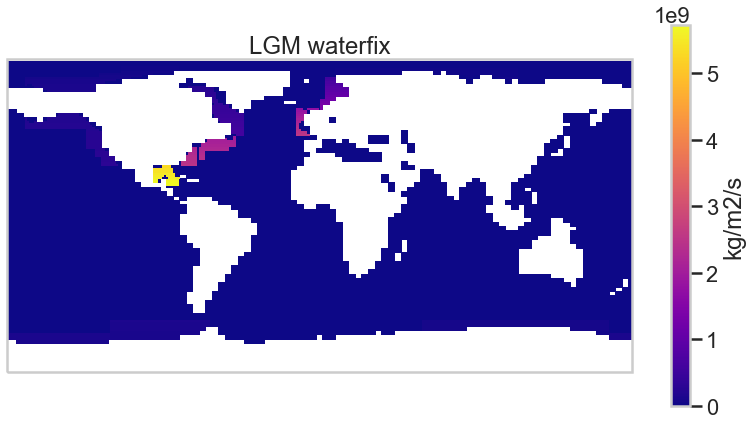

In [19]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))

cmap = axMap.pcolormesh(lon_lsm_b, lat_lsm_b, saving.masking_method(spread_discharge[0], lsm),
                        cmap='plasma', transform=ccrs.PlateCarree())

axMap.set_global()
axMap.set_title("LGM waterfix")
figMap.colorbar(mappable=cmap, ax=axMap, label="kg/m2/s")

## Spreading algorithm

Proposed utilisation of the spreading algorith. takes a discharge array in input to return the corresponding discharge array. Also perform a check at the end to make sure the spreading succeded.

In [20]:
lat, lon = spreading.LatAxis(lat_wfix[:]), spreading.LonAxis(lon_wfix[:])
umgrid = spreading.Grid(lat, lon)


In [21]:
discharge_spread = spreading.spreading(discharge, ds_lsm, ds_wfix)

__ Spreading algorithm
____ Spreading in {'name': 'US_East_Coast', 'loc': 147 ocean cells in the region, 'region': 125 ocean cells in the region}
____ Spreading in {'name': 'Greenland_Arctic', 'loc': 163 ocean cells in the region, 'region': 163 ocean cells in the region}
____ Spreading in {'name': 'N_American_Arctic', 'loc': 390 ocean cells in the region, 'region': 355 ocean cells in the region}
____ Spreading in {'name': 'Gulf_of_Mexico', 'loc': 96 ocean cells in the region, 'region': 72 ocean cells in the region}
____ Spreading in {'name': 'East_Pacific', 'loc': 292 ocean cells in the region, 'region': 270 ocean cells in the region}
____ Spreading in {'name': 'Russia_Pacific', 'loc': 21 ocean cells in the region, 'region': 12 ocean cells in the region}
____ Spreading in {'name': 'LabradorSea_BaffinBay', 'loc': 228 ocean cells in the region, 'region': 175 ocean cells in the region}
____ Spreading in {'name': 'Atlantic_GreenlandIceland', 'loc': 116 ocean cells in the region, 'region': 

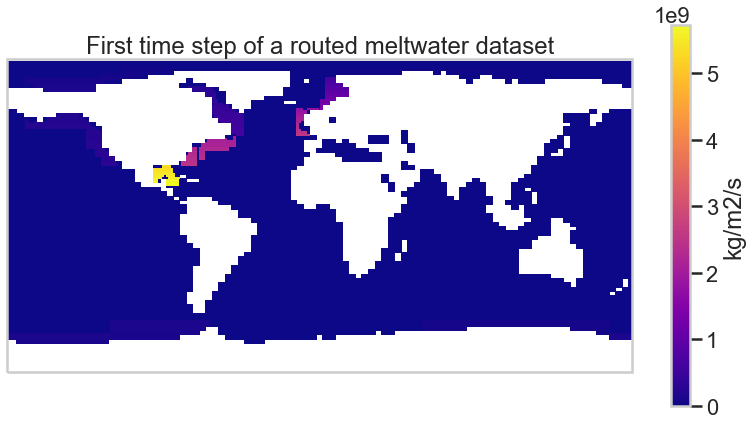

In [22]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))

# Masking method is necessary to transform 0 to nan.
cmap = axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, saving.masking_method(discharge_spread[0], lsm),
                        cmap='plasma', transform=ccrs.PlateCarree())
axMap.set_global()
axMap.set_title("First time step of a routed meltwater dataset")
figMap.colorbar(mappable=cmap, ax=axMap, label="kg/m2/s")

## Step 3 : Add waterfix to the spread mask

In [26]:
wfix_3d = spreading.convert_waterfix(wfix, discharge_spread, tb.surface_matrix(lon_lsm, lat_lsm))
discharge_total = discharge_spread + wfix_3d

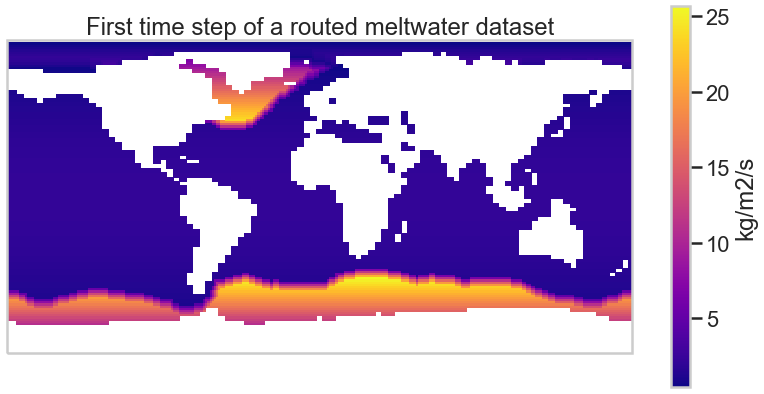

In [28]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))

# Masking method is necessary to transform 0 to nan.
cmap = axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, saving.masking_method(wfix_3d[0], lsm),
                        cmap='plasma', transform=ccrs.PlateCarree())
axMap.set_global()
axMap.set_title("First time step of a routed meltwater dataset")
figMap.colorbar(mappable=cmap, ax=axMap, label="kg/m2/s")

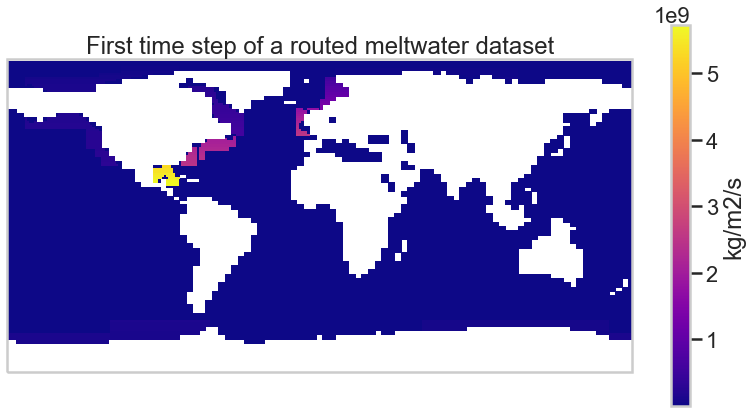

In [27]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))

# Masking method is necessary to transform 0 to nan.
cmap = axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, saving.masking_method(discharge_total[0], lsm),
                        cmap='plasma', transform=ccrs.PlateCarree())
axMap.set_global()
axMap.set_title("First time step of a routed meltwater dataset")
figMap.colorbar(mappable=cmap, ax=axMap, label="kg/m2/s")

## Step 4 - Flux check

Flux check is used to verify the spreading between a routed and a spread array. It is already implemented in the spreading main method but can also be used a posteriori to vcheck the coupling between a routed and a spread file. For it to work, the mask of saved qfiles should be removed.

In [24]:
# Add a time dimension to the waterfix and convert it to m3/s

spread_mw = discharge_spread - wfix_3d
discharge_others = spreading.get_discharge_others(discharge, sr)

spreading.flux_check(discharge, spread_mw, discharge_others, wfix_3d, discharge_spread)

Spreading of water succeded

Checking.
If all is correct then:
    [1] = [2] + [3] 
    [6] = [3] + [4] + [5] 
    [6] = [7]
[1] discharge_flux (m3/s):  1496090553981.5947
[2] spreaded_flux (m3/s):  1487331142205.8135
[3] discharge_others_flux (m3/s):  8759485715.897024
[4] wfix_flux(m3/s):  112462.55758981367
[5] total_flux_init (m3/s):  1496090666444.1519
[6] total_flux (m3/s):  1487331254668.3706 

[1] = [2] + [3]: True
[6] = [2] + [4]: True
[5] = [6] + [3]: True
